In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import TensorFlowV2Classifier

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')


In [3]:
# Take a subset of the dataset (e.g., first 100 examples)
subset_size = 100
x_test_subset = x_test[:subset_size] / 255.0
y_test_subset = to_categorical(y_test[:subset_size], 100)

In [4]:
# Function to build the model
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [5]:
# Build and compile model for CIFAR-100
model = build_model(100)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Create ART classifier
classifier = TensorFlowV2Classifier(model=model, nb_classes=100, input_shape=(32, 32, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())


In [8]:
# C&W Attack with reduced confidence and iterations
cw_attack = CarliniL2Method(classifier=classifier, confidence=0.5, batch_size=16, max_iter=100)
x_test_cw = cw_attack.generate(x=x_test_subset)

# Evaluate the model on the adversarial examples
loss, accuracy = model.evaluate(x_test_cw, y_test_subset, verbose=0)
print(f"CIFAR-100 C&W Attack Accuracy: {accuracy * 100:.2f}%")

C&W L_2: 100%|██████████| 7/7 [25:16<00:00, 216.61s/it]


CIFAR-100 C&W Attack Accuracy: 1.00%


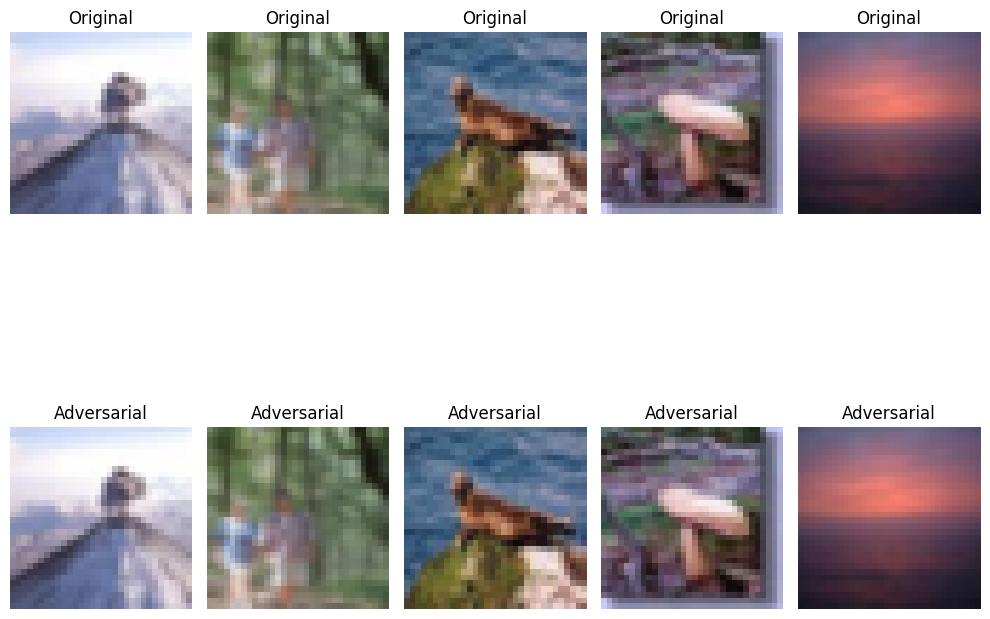

In [9]:
# Visualization function
def visualize_examples(x_test, x_adv, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(x_adv[i])
        plt.title("Adversarial")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize adversarial examples
visualize_examples(x_test_subset, x_test_cw)